# MODEL BUILDING

### Hans Schumann and Augie Doebling
### 2.May 2018

Looking at building a model to show the probability of bitcoin increasing price over a given time.

In [2]:
"""
This file will take data from the SQL database and perform exploratory analysis for model building
"""

## import all packages / other files needed
import pymysql
import numpy as np
import pandas as pd
import helpers
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
## create credentials
DB_USERNAME = ""
DB_PASSWORD = ""
with open("creds.txt", "r") as creds:
    DB_USERNAME = creds.readline()[:-1]
    DB_PASSWORD = creds.readline()[:-1]

connection = pymysql.connect(host='seniorproject.cxbqypcd9gwp.us-east-2.rds.amazonaws.com',
                             user=DB_USERNAME,
                             password=DB_PASSWORD,
                             db='seniorproject')
## get all the rows from the sql database
cursor = connection.cursor()
sentimentQuery = "SELECT * FROM sentiment"
cursor.execute(sentimentQuery)
sentimentRows = cursor.fetchall()
## put all the rows in a dataframe
sentiment = pd.DataFrame(list(sentimentRows),
                         columns = ['key','id','datetime','currency','price','logprice',
                                    'times','count','favorites','retweets','avg_sentiment'])

## add day of the week variable
sentiment['datetime'] = pd.to_datetime(sentiment['datetime'])
sentiment['day_of_week'] = sentiment['datetime'].dt.weekday_name
sentiment = pd.concat([sentiment,pd.get_dummies(sentiment['day_of_week'])],axis = 1)

## convert necessary columns to numeric
sentiment['price'] = pd.to_numeric(sentiment['price'])
sentiment['logprice'] = pd.to_numeric(sentiment['logprice'])
sentiment['times'] = pd.to_numeric(sentiment['times'])
sentiment['count'] = pd.to_numeric(sentiment['count'])
sentiment['favorites'] = pd.to_numeric(sentiment['favorites'])
sentiment['retweets'] = pd.to_numeric(sentiment['retweets'])
sentiment['avg_sentiment'] = pd.to_numeric(sentiment['avg_sentiment'])

For this first model, we will look at the past data from a week prior.  Using this, we can develop a model to predict the probability of bitcoin increasing in price at a certain time in the future.

First we will set up the data and then divide it into a training and testing set

In [45]:
## determine time to look back in minutes
t = 1440  # this is one day
t2 = 2880 # this is two day
t3 = 4320 # this is three days

dummy_df = sentiment

dummy_df['sum1_count'] = sentiment['count'].rolling(t-1).sum().fillna(method = 'bfill')
dummy_df['sum1_favorites'] = sentiment['favorites'].rolling(t-1).sum().fillna(method = 'bfill')
dummy_df['sum1_retweets'] = sentiment['retweets'].rolling(t-1).sum().fillna(method = 'bfill')
dummy_df['sum1_avg_sentiment'] = sentiment['avg_sentiment'].rolling(t-1).sum().fillna(method = 'bfill')

dummy_df['sum2_count'] = sentiment['count'].rolling(t2-1).sum().fillna(method = 'bfill') - dummy_df['sum1_count']
dummy_df['sum2_favorites'] = sentiment['favorites'].rolling(t2-1).sum().fillna(method = 'bfill') - dummy_df['sum1_favorites']
dummy_df['sum2_retweets'] = sentiment['retweets'].rolling(t2-1).sum().fillna(method = 'bfill') - dummy_df['sum1_retweets']
dummy_df['sum2_avg_sentiment'] = sentiment['avg_sentiment'].rolling(t2-1).sum().fillna(method = 'bfill') - dummy_df['sum1_avg_sentiment']

dummy_df['sum3_count'] = sentiment['count'].rolling(t3-1).sum().fillna(method = 'bfill') - (dummy_df['sum1_count'] + dummy_df['sum2_count'])
dummy_df['sum3_favorites'] = sentiment['favorites'].rolling(t3-1).sum().fillna(method = 'bfill') - (dummy_df['sum1_favorites'] + dummy_df['sum2_favorites'])
dummy_df['sum3_retweets'] = sentiment['retweets'].rolling(t3-1).sum().fillna(method = 'bfill') - (dummy_df['sum1_retweets'] + dummy_df['sum2_retweets'])
dummy_df['sum3_avg_sentiment'] = sentiment['avg_sentiment'].rolling(t3-1).sum().fillna(method = 'bfill') - (dummy_df['sum1_avg_sentiment'] + dummy_df['sum2_avg_sentiment'])

In [19]:
## create price changes for certain time periods in advance
dummy_df['price_change_1day'] = (dummy_df['price'].shift(-1440) - dummy_df['price']).fillna(method = 'ffill')
dummy_df['price_change_2days'] = (dummy_df['price'].shift(-2880) - dummy_df['price']).fillna(method = 'ffill')
dummy_df['price_change_3days'] = (dummy_df['price'].shift(-4320) - dummy_df['price']).fillna(method = 'ffill')

In [46]:
## divide into the training and testing set
x_vars = ['count','favorites','retweets','avg_sentiment',
          'sum_count','sum_favorites','sum_retweets','sum_avg_sentiment',
          'sum2_count','sum2_favorites','sum2_retweets','sum2_avg_sentiment',
          'sum3_count','sum3_favorites','sum3_retweets','sum3_avg_sentiment',
          'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
y_var = 'price_change_1day'

dummy_df = dummy_df.sample(frac = 1)
n = int(0.75 * len(dummy_df))
train = dummy_df[:n]
test = dummy_df[n:]
x_train = train[x_vars]
x_test = test[x_vars]


y_train = train[y_var]
y_test = test[y_var]

In [47]:
x_train

,count,favorites,retweets,avg_sentiment,sum_count,sum_favorites,sum_retweets,sum_avg_sentiment,sum2_count,sum2_favorites,...,sum3_retweets,sum3_avg_sentiment,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
117119,25,3,5,0.103242,12773.0,8077.0,8215.0,101.005414,12072.0,8461.0,...,6078.0,123.811383,0,0,1,0,0,0,0,0
304325,3,9,3,0.055556,19807.0,39268.0,39611.0,106.607075,17338.0,22206.0,...,22330.0,122.436083,0,0,0,1,0,0,0,0
132276,15,0,0,0.080833,10694.0,8619.0,14291.0,135.348423,12603.0,11627.0,...,12084.0,146.183863,0,0,0,0,0,0,1,0
170381,11,3,2,0.082231,12433.0,15782.0,17761.0,111.514233,14218.0,17560.0,...,11459.0,112.560274,1,0,0,0,0,0,0,1
134429,8,2,0,0.134375,10914.0,9956.0,10354.0,145.390852,10602.0,8338.0,...,16043.0,135.732008,0,1,0,0,0,0,0,0
79507,16,6,10,0.096370,12035.0,8763.0,7191.0,119.619802,10218.0,6943.0,...,9592.0,117.795953,0,1,0,0,0,0,0,0
111693,8,0,0,0.054167,12205.0,8946.0,9250.0,99.491786,12009.0,10412.0,...,8476.0,114.491625,0,0,0,0,0,1,0,0
83318,6,2,1,0.170833,12713.0,8052.0,8333.0,101.913531,13987.0,10596.0,...,8785.0,109.696626,0,0,0,0,1,0,0,0
294906,21,4,1,-0.029394,13345.0,21072.0,28865.0,113.233651,14035.0,21812.0,...,35557.0,108.722204,1,0,0,0,0,0,0,1
323080,16,15,7,0.113839,46509.0,79832.0,78009.0,111.813291,29362.0,51248.0,...,35306.0,110.741530,0,0,1,0,0,0,0,0


### Linear Model

In [48]:
from sklearn import linear_model
lm = linear_model.LinearRegression()
lm.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [49]:
lm.score(x_test, y_test)

0.12423591946233382

### KNN Regressor
For the price increase of Bitcoin in the next day.

In [65]:
from sklearn.neighbors import KNeighborsRegressor

knn_reg = KNeighborsRegressor(n_neighbors = 101)
knn_reg.fit(x_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=101, p=2,
          weights='uniform')

In [66]:
knn_reg.score(x_test,y_test)
y_pred = knn_reg.predict(x_test)

0.96895880369540821

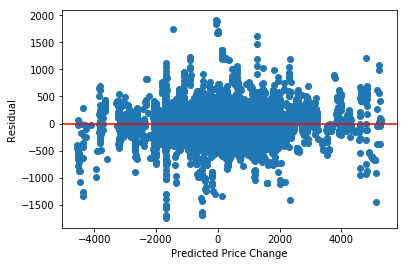

In [76]:
plt.plot(y_pred,y_test - y_pred,'o')
plt.ylabel('Residual')
plt.xlabel('Predicted Price Change')
plt.axhline(y = 0,color = 'red')

This may be an artifically enhanced model due to the random split of the training and testing set.  A more accurate way may be to use the first 70% to predict the final 30%.  This may have problems though due to the lack of extreme price changes until late.  
As of right now though, the KNN seems to be undoubtedly the most promising way to predict price changes in Bitcoin.

### Logistic Regression

In [50]:
from sklearn import linear_model
lm = linear_model.LogisticRegression()
lm.fit(x_train, y_train > 0)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [51]:
lm.score(x_test, y_test > 0),np.mean(y_test > 0)

(0.61184854801958599, 0.61332234449992729)

### KNN Classifier
For whether or not Bitcoin increases price.

In [61]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 101)
knn.fit(x_train,y_train > 0)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=101, p=2,
           weights='uniform')

In [62]:
knn.score(x_test,y_test > 0)

0.95478741455374028

### Convolutional NN

This will probably be the best, but I am unsure of how exactly it will work

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout
from keras.optimizers import SGD
from keras.utils import np_utils

In [30]:
model = Sequential()
model.add()